In [99]:
import pandas as pd
from sklearn import model_selection
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import numpy as np
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torch.nn.init as init
import torch.nn.functional as F
import os
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, average_precision_score

In [150]:
def model_evaluate(net, test_dataloader):
    net.eval()  # 设置模型为评估模式
    y_true = []
    y_scores = []

    with torch.no_grad():
        for sample in test_dataloader:
            inputs = sample[0]
            labels = sample[1]
            labels = labels.unsqueeze(1)  # 确保标签的形状为 (batch_size, 1)
            labels = labels.float()

            # 获取模型输出，经过sigmoid后得到概率
            probabilities = torch.sigmoid(net(inputs))  # 二分类任务，输出一个概率值

            # 由于输出是一个概率，直接使用它来作为正类的概率
            y_scores.extend(probabilities.numpy())
            y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # 计算F1 Score和AUC值
    y_pred = np.round(y_scores)  # 将概率转换为0或1
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)
    aupr = average_precision_score(y_true, y_scores)

    # 返回AUC, F1, AUPR
    return auc, f1, aupr

In [100]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.position_encoding = self.create_position_encoding()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # 将每个样本的 520 维特征转换为 40x13 的二维张量
        sample = self.features[idx].reshape(16, 40).astype(np.float32).T
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        position_encoding = self.position_encoding.numpy()  # shape (seq_len, input_dim)
        # sample_with_pos = sample + self.position_encoding
        return torch.tensor(sample), label
    
    def create_position_encoding(self, seq_len = 40, input_dim = 16):
        # 获取位置序列，shape: (seq_len, 1)
        position = np.arange(0, seq_len).reshape(-1, 1)  # 生成一个形状为 (seq_len, 1) 的位置向量 [0, 1, 2, ..., seq_len-1]

        # 计算不同维度的扩展因子，shape: (input_dim // 2,)
        div_term = np.exp(np.arange(0, input_dim // 2) * -(np.log(10000.0) / input_dim))  # 计算每个位置特征的频率调整因子

        # 创建一个形状为 (seq_len, input_dim) 的位置编码矩阵
        pos_enc = np.zeros((seq_len, input_dim))  # 初始化一个零矩阵

        # 对偶数位置使用 sin 函数，计算每个位置的偶数维度的值
        pos_enc[:, 0::2] = np.sin(position * div_term)  # 偶数位置使用正弦函数
        
        # 对奇数位置使用 cos 函数，计算每个位置的奇数维度的值
        pos_enc[:, 1::2] = np.cos(position * div_term)  # 奇数位置使用余弦函数

        return torch.tensor(pos_enc, dtype=torch.float32)  # 将生成的 numpy 数组转换为 torch tensor

class CustomDataset_pos_encoded(Dataset):
    def __init__(self, features, labels, input_dim=16, seq_len=40):
        self.features = features
        self.labels = labels
        self.input_dim = input_dim  # 动态传入的特征维度
        self.seq_len = seq_len      # 序列长度
        self.position_encoding = self.create_position_encoding(seq_len, input_dim)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # 将每个样本的特征转换为 (seq_len, input_dim) 的二维张量
        sample = self.features[idx].reshape(self.input_dim, self.seq_len).astype(np.float32).T  # 转置为 (input_dim, seq_len)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        position_encoding = self.position_encoding.numpy()  # 获取位置编码，shape: (seq_len, input_dim)
        
        # 逐元素相加样本和位置编码
        sample_with_pos = sample + position_encoding  # shape: (seq_len, input_dim)

        return torch.tensor(sample_with_pos), label

    def create_position_encoding(self, seq_len, input_dim):
        position = np.arange(seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, input_dim, 2) * -(np.log(10000.0) / input_dim))

        pos_enc = np.zeros((seq_len, input_dim))
        pos_enc[:, 0::2] = np.sin(position * div_term)

        if input_dim % 2 != 0:
            pos_enc[:, 1::2] = np.cos(position * div_term[:-1])
        else:
            pos_enc[:, 1::2] = np.cos(position * div_term)


        return torch.tensor(pos_enc, dtype=torch.float32)  # 将生成的 numpy 数组转换为 torch tensor


In [101]:
def equal_kind(data_df):
    df_y0 = data_df[data_df['label'] == 0]
    df_y1 = data_df[data_df['label'] == 1]

    # 确定两个子集中数量较少的那个
    min_count = min(len(df_y0), len(df_y1))

    # 从两个子集中随机选择等量的样本
    df_y0_balanced = df_y0.sample(n=min_count, random_state=42) if len(df_y0) > min_count else df_y0
    df_y1_balanced = df_y1.sample(n=min_count, random_state=42) if len(df_y1) > min_count else df_y1

    # 合并这两个平衡后的子集
    balanced_df = pd.concat([df_y0_balanced, df_y1_balanced])
    # 打乱合并后的数据集的顺序
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

In [151]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

class Animator:
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=None, nrows=1, ncols=1, figsize=(3.5, 2.5),
                 xtick_size=10, ytick_size=10, xlabel_size=12, ylabel_size=12):
        if fmts is None:
            fmts = ['-', 'm--', 'g-', 'r:']
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend,
                                                 xtick_size, ytick_size, xlabel_size, ylabel_size)
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend,
                 xtick_size, ytick_size, xlabel_size, ylabel_size):
        """设置matplotlib的轴。"""
        axes.set_xlabel(xlabel, fontsize=xlabel_size)
        axes.set_ylabel(ylabel, fontsize=ylabel_size)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()
        axes.tick_params(axis='x', labelsize=xtick_size)
        axes.tick_params(axis='y', labelsize=ytick_size)

    def add(self, x, y):
        """向图表中添加多个数据点。"""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display(self.fig)
        clear_output(wait=True)

In [152]:
class Accumulator:
    """
    在n个变量上累加
    """
    def __init__(self, n):
        self.data = [0.0] * n       # 创建一个长度为 n 的列表，初始化所有元素为0.0。

    def add(self, *args):           # 累加
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):                # 重置累加器的状态，将所有元素重置为0.0
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):     # 获取所有数据
        return self.data[idx]

In [153]:
def accuracy(y_hat, y):
    """
    计算正确的数量
    :param y_hat:
    :param y:
    :return:
    """
    # if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    #     y_hat = y_hat.argmax(axis=1)            # 在每行中找到最大值的索引，以确定每个样本的预测类别
    # cmp = y_hat.type(y.dtype) == y
    # return float(cmp.type(y.dtype).sum())
    y_hat = F.sigmoid(y_hat) # 将模型原始输出转化为概率
    y_hat = (y_hat >= 0.5).float()  # 将概率转化为 0 或 1
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def evaluate_accuracy(net, data_iter):
    """
    计算指定数据集的精度
    :param net:
    :param data_iter:
    :return:
    """
    if isinstance(net, torch.nn.Module):
        net.eval()                  # 通常会关闭一些在训练时启用的行为
    metric = Accumulator(2)
    with torch.no_grad():
        for sample in data_iter:
            X = sample[0]
            y = sample[1]
            y_hat = net(X)
            y = y.unsqueeze(1)
            y = y.float()
            metric.add(accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    """
    训练模型一轮
    :param net:是要训练的神经网络模型
    :param train_iter:是训练数据的数据迭代器，用于遍历训练数据集
    :param loss:是用于计算损失的损失函数
    :param updater:是用于更新模型参数的优化器
    :return:
    """
    if isinstance(net, torch.nn.Module):  # 用于检查一个对象是否属于指定的类（或类的子类）或数据类型。
        net.train()

    # 训练损失总和， 训练准确总和， 样本数
    metric = Accumulator(3)

    for sample in train_iter:
        X = sample[0]
        y = sample[1]
        # X = X.view(X.shape[0], 1, -1)
        y_hat = net(X) # y_hat不是一个概率值，因为模型输出层未安装sigmoid
        y = y.unsqueeze(1)
        y = y.float()
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):  # 用于检查一个对象是否属于指定的类（或类的子类）或数据类型。
            # 使用pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()  # 方法用于计算损失的平均值
            updater.step()
        else:
            # 使用定制（自定义）的优化器和损失函数
            l.sum().backward()
            updater(X.shape())
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch4(net, train_iter, test_iter, loss, num_epochs, updater, scheduler = None, save_best=True, checkpoint_dir='./selfattention_checkpoints_droupout0.15'):
    """
    训练模型
    :param net: 模型
    :param train_iter: 训练数据的迭代器
    :param test_iter: 测试数据的迭代器
    :param loss: 损失函数
    :param num_epochs: 训练的轮数
    :param updater: 参数更新器/优化器
    """
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # 初始化动画绘制器
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'], figsize=(7, 7), xlabel_size=14, xtick_size=12, ylabel_size=14, ytick_size=12)
    
    best_acc = 0.0  # 跟踪最高的测试精度
    best_epoch = 0  # 保存最佳模型的epoch
    best_auc =0.0
    
    for epoch in range(num_epochs):
        # 训练模型一轮，并返回训练损失和训练精度
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        # 计算测试集上的精度
        test_acc = evaluate_accuracy(net, test_iter)
        # 计算测试集上的AUROC
        all_labels = []
        all_preds = []
        net.eval()  # 设置模型为评估模式
        with torch.no_grad():
            for X_batch, y_batch in test_iter:
                outputs = net(X_batch)
                all_labels.append(y_batch.detach().numpy())
                all_preds.append(outputs.detach().numpy()) # 直接使用原始输出作为预测值，sklearn的roc_auc_score不需要归一化为的概率为输入
        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)
        test_auc = roc_auc_score(all_labels, all_preds)

        if  test_auc > best_auc:
            best_auc = test_auc
            best_epoch = epoch
            # 保存模型
            if save_best == True:
                checkpoint_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch + 1}_auc_{best_auc:.3f}.pth')
                torch.save(net.state_dict(), checkpoint_path)
            
        # 添加当前轮次的训练损失、训练精度和测试精度到动画绘制器中
        animator.add(epoch + 1, train_metrics + (test_acc,))
        if scheduler != None:
            scheduler.step()
        # 打印当前轮次的训练损失和训练精度
        print(f'Epoch {epoch + 1}, Loss {train_metrics[0]:.3f}, '
              f'Train acc {train_metrics[1]:.3f}, Test acc {test_acc:.3f}')
    # 保存训练过程的动画图像
    plt.show()
    print(f"Best Test AUC: {best_auc:.3f} at epoch {best_epoch + 1}")
    
# ch5版本，取消早停，只保存最后一个epoch的模型，返回多种评估指标,不画图
def train_ch5(net, train_iter, test_iter, loss, num_epochs, updater, scheduler = None, save_best=True, checkpoint_dir='./selfattention_checkpoints'):
    """
    训练模型
    :param net: 模型
    :param train_iter: 训练数据的迭代器
    :param test_iter: 验证数据的迭代器，用于早停
    :param test_iter: 测试数据的迭代器
    :param loss: 损失函数
    :param num_epochs: 训练的轮数
    :param updater: 参数更新器/优化器
    """
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    
    # best_acc = 0.0  # 跟踪最高的测试精度
    best_epoch = 0  # 保存最佳模型的epoch
    best_auroc = 0 
    best_F1 = 0
    # best_auc =0.0
    best_aurp = 0 #最佳的auroc，F1，aurp都跟随最佳accuracy
    
    for epoch in range(num_epochs):
        # 训练模型一轮，并返回训练损失和训练精度
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        # 计算测试集上的精度
        test_acc = evaluate_accuracy(net, test_iter)
        # 计算验证集上的AUROC
        all_labels = []
        all_preds = []
        net.eval()  # 设置模型为评估模式
        with torch.no_grad():
            for X_batch, y_batch in test_iter:
                outputs = net(X_batch)
                all_labels.append(y_batch.detach().numpy())
                all_preds.append(outputs.detach().numpy()) # 直接使用原始输出作为预测值，sklearn的roc_auc_score不需要归一化为的概率为输入
        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)
        test_auc = roc_auc_score(all_labels, all_preds)

    # 防止信息泄露，不在test set上进行早停，保存最后一个epoch的数据
    if save_best == True:
        checkpoint_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch + 1}_auc_{test_auc:.3f}.pth')
        torch.save(net.state_dict(), checkpoint_path)       

            
    # 获取本次训练完成模型的评估信息
    best_model_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch + 1}_auc_{test_auc:.3f}.pth')
    saved_model = net
    saved_model.load_state_dict(torch.load(best_model_path))
    saved_model.eval()  # 切换为评估模式
    best_auroc, best_F1, best_aurp = model_evaluate(saved_model, test_iter)
    return test_acc, best_auroc, best_F1, best_aurp


In [158]:
class ColumnAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ColumnAttention, self).__init__()
        # 自注意力的权重
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        # 输入 x 维度: (batch_size, 40, 13)
        Q = self.query(x)  # (batch_size, 40, hidden_dim)
        K = self.key(x)    # (batch_size, 40, hidden_dim)
        V = self.value(x)  # (batch_size, 40, hidden_dim)
        
        # 计算注意力分数: Q * K^T
        attention_scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch_size, 40, 40)
        attention_scores = attention_scores / (K.size(-1) ** 0.5)  # 缩放
        
        # 通过softmax获得注意力权重
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch_size, 40, 40)
        
        # 应用注意力权重到值上
        attended_values = torch.matmul(attention_weights, V)  # (batch_size, 40, hidden_dim)
        output = self.fc(attended_values) # (batch_size, 40, 13)
        return output, attention_weights
    
class RowAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RowAttention, self).__init__()
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        Q = self.query(x)  # (batch_size, 13, hidden_dim)
        K = self.key(x)    # (batch_size, 13, hidden_dim)
        V = self.value(x)  # (batch_size, 13, hidden_dim)
        
        attention_scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch_size, 13, 13)
        attention_scores = attention_scores / (K.size(-1) ** 0.5)  # Scaling
        
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch_size, 13, 13)
        
        attended_values = torch.matmul(attention_weights, V)  # (batch_size, 13, hidden_dim)
        output = self.fc(attended_values)  # (batch_size, 13, 40)
        return output, attention_weights

class Feed_Forward(nn.Module):
    def __init__(self, input_dim, d_ff, dropout_rate=0.1):
        super(Feed_Forward, self).__init__()
        # 第一个全连接层，输入维度为 input_dim，输出维度为 d_ff
        self.fc1 = nn.Linear(input_dim, d_ff)
        # 第二个全连接层，输入维度为 d_ff，输出维度为 input_dim
        self.fc2 = nn.Linear(d_ff, input_dim)
        # Dropout层，用于防止过拟合
        self.dropout = nn.Dropout(dropout_rate)
        # 激活函数：ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        # 通过第一个全连接层
        x1 = self.fc1(x)
        # 激活函数
        x1 = self.relu(x1)
        # Dropout
        x1 = self.dropout(x1)
        # 通过第二个全连接层
        x2 = self.fc2(x1)
        # 残差连接：输入与输出相加
        out = x + x2  # x 是输入，x2 是第二个全连接层的输出
        return out

class CrossAttentionModel(nn.Module):
    def __init__(self, input_dim=13, seq_len=40, hidden_dim=64, output_dim=1, d_ff= 32, dropout_rate = 0.15):
        super(CrossAttentionModel, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.column_attention = ColumnAttention(input_dim, hidden_dim)
        self.row_attention = RowAttention(input_dim = 40, hidden_dim = 64)
        self.layer_norm1 = nn.LayerNorm(input_dim)
        self.layer_norm2 = nn.LayerNorm(input_dim)
        self.ffn1 = Feed_Forward(input_dim, d_ff, dropout_rate)
        self.ffn2 = Feed_Forward(input_dim, d_ff, dropout_rate)
        # 全连接层
        self.fc1 = nn.Linear(input_dim * seq_len, 128)
        self.fc2 = nn.Linear(128, output_dim)
        # self.sigmoid = nn.Sigmoid()
        self.droupout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # 输入 x 维度: (batch_size, 40, 13)
        x = x.view(-1, self.seq_len, self.input_dim)  # 调整输入形状
        x, attention_drop1 = self.column_attention(x)
        x = self.layer_norm1(x)  # Layer Norm after Column Attention
        x = self.ffn1(x)  # Feed-Forward Neural Network
        # return x
        # Step 2: Row Attention
        x = x.transpose(1, 2)  # Change shape to (batch_size, 13, 40) for row attention
        # return x
        x, attention_drop2 = self.row_attention(x)

        x = x.transpose(1, 2)
        # return x
        x = self.layer_norm2(x)  # Layer Norm after Row Attention
        x = self.ffn2(x)  # Feed-Forward Neural Network
        
        # 将输出展平
        attention_output = x.view(-1, self.seq_len * self.input_dim)
        
        # 全连接层
        x = F.relu(self.fc1(attention_output))  # (batch_size, 128)
        x = self.droupout(x) # (batch_size, 128)
        x = self.fc2(x)  # (batch_size, output_dim = 1)

        return x
    
    def _initialize_weights(self):
        # 对 column_attention 的 linear 层进行初始化
        init.kaiming_normal_(self.column_attention.query.weight, nonlinearity='relu')
        init.kaiming_normal_(self.column_attention.key.weight, nonlinearity='relu')
        init.kaiming_normal_(self.column_attention.value.weight, nonlinearity='relu')
        
        # 对 row_attention 的 linear 层进行初始化
        init.kaiming_normal_(self.row_attention.query.weight, nonlinearity='relu')
        init.kaiming_normal_(self.row_attention.key.weight, nonlinearity='relu')
        init.kaiming_normal_(self.row_attention.value.weight, nonlinearity='relu')
        
        # 对 ffn1 和 ffn2 的 linear 层进行初始化
        init.kaiming_normal_(self.ffn1.fc1.weight, nonlinearity='relu')
        init.kaiming_normal_(self.ffn1.fc2.weight, nonlinearity='relu')
        init.kaiming_normal_(self.ffn2.fc1.weight, nonlinearity='relu')
        init.kaiming_normal_(self.ffn2.fc2.weight, nonlinearity='relu')
        
        # 对 fc1 和 fc2 进行初始化
        init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        
        # 初始化偏置项为 0
        if self.column_attention.query.bias is not None:
            init.constant_(self.column_attention.query.bias, 0)
            init.constant_(self.column_attention.key.bias, 0)
            init.constant_(self.column_attention.value.bias, 0)
        
        if self.row_attention.query.bias is not None:
            init.constant_(self.row_attention.query.bias, 0)
            init.constant_(self.row_attention.key.bias, 0)
            init.constant_(self.row_attention.value.bias, 0)
        
        if self.ffn1.fc1.bias is not None:
            init.constant_(self.ffn1.fc1.bias, 0)
            init.constant_(self.ffn1.fc2.bias, 0)
        
        if self.ffn2.fc1.bias is not None:
            init.constant_(self.ffn2.fc1.bias, 0)
            init.constant_(self.ffn2.fc2.bias, 0)
        
        if self.fc1.bias is not None:
            init.constant_(self.fc1.bias, 0)
        if self.fc2.bias is not None:
            init.constant_(self.fc2.bias, 0)

In [155]:
# 合并所有样本
folder_path = '/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/resources/SelfAttentionSamples/labels/'

# 获取该文件夹下所有 CSV 文件的文件名，并按文件名顺序排序
csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

# 创建一个空的列表，用于存储所有的 DataFrame
dfs = []

# 依次读取每个 CSV 文件并将其添加到列表中
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)  # 读取 CSV 文件
    dfs.append(df)  # 将 DataFrame 添加到列表中

# 将所有的 DataFrame 按列合并
y_df = pd.concat(dfs, axis=0)

# 设置文件夹路径
folder_path = '/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/resources/SelfAttentionSamples/samples/'
# 获取该文件夹下所有 CSV 文件的文件名，并按文件名顺序排序
csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
# 创建一个空的列表，用于存储所有的 DataFrame
dfs = []
# 依次读取每个 CSV 文件并将其添加到列表中
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)  # 读取 CSV 文件
    dfs.append(df)  # 将 DataFrame 添加到列表中
# 将所有的 DataFrame 按列合并
X_df = pd.concat(dfs, axis=0)

merged_df = pd.merge(X_df, y_df, on='sample', how='left')
merged_df = equal_kind(merged_df)
# 将特征列转换为 NumPy 数组，并将标签列提取出来
features = merged_df.iloc[:, 1:-1].values  # 第一列为 'sample'，最后一列为 'label'
labels = merged_df.iloc[:, -1].values  # 标签列
dataset = CustomDataset(features, labels)
# dataset = CustomDataset_pos_encoded(features, labels)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [159]:
# 不加位置编码，不进行早停
dataset = CustomDataset(features, labels)
# dataset = CustomDataset_pos_encoded(features, labels)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = CrossAttentionModel(input_dim=16, seq_len=40, hidden_dim=64, dropout_rate=0.15)
model._initialize_weights()

num_epochs = 45
loss = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
train_ch5(model, train_loader, test_loader, loss, num_epochs, optimizer, save_best=True, checkpoint_dir='/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/ML_models/eight_sample_11features_test/DL_saved/attnetion_plot_45epoch_0.15drop_nopos/') #, scheduler)

(0.7182835820895522,
 0.8131309614982941,
 0.7279279279279279,
 0.8010577221248771)

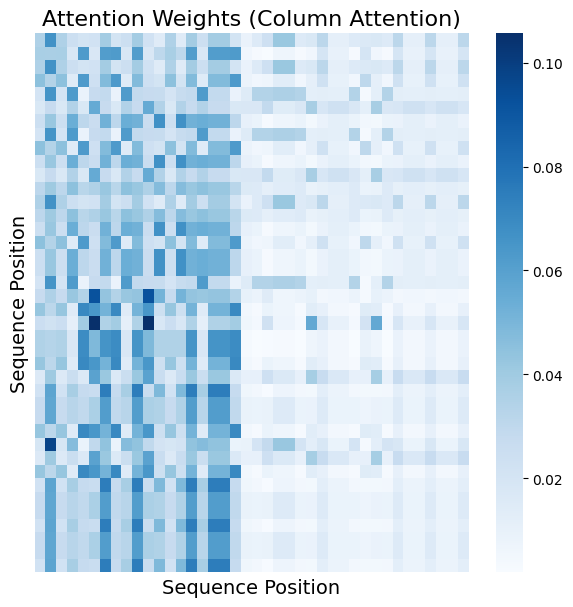

In [187]:
model = CrossAttentionModel(input_dim=16, seq_len=40, hidden_dim=64, dropout_rate=0.15) 
model.load_state_dict(torch.load('/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/ML_models/eight_sample_11features_test/DL_saved/attnetion_plot_45epoch_0.15drop_nopos/best_model_epoch_45_auc_0.813.pth'))
model.eval()

for x, y in test_loader:
    # print(x.shape, y.shape)
    input_tensor = x
    break

attention_weights_list = []  # 用于存储 attention_weights

def capture_column_attention_weights(module, input, output):
    # 这里的output[1]是注意力权重
    attention_weights = output[1]  # shape: (batch_size, seq_len, seq_len)
    attention_weights_list.append(attention_weights.cpu().detach().numpy())


column_hook = model.column_attention.register_forward_hook(capture_column_attention_weights)
# input_tensor = torch.rand(64, 40, 16)
output = model(input_tensor)
first_sample_attention_weights = attention_weights_list[0][0]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.heatmap(first_sample_attention_weights, cmap='Blues', annot=False, xticklabels=False, yticklabels=False)
plt.title('Attention Weights (Column Attention)', fontsize=16)
plt.xlabel('Sequence Position', fontsize=14)
plt.ylabel('Sequence Position', fontsize=14)
plt.show()

# 移除钩子
column_hook.remove()

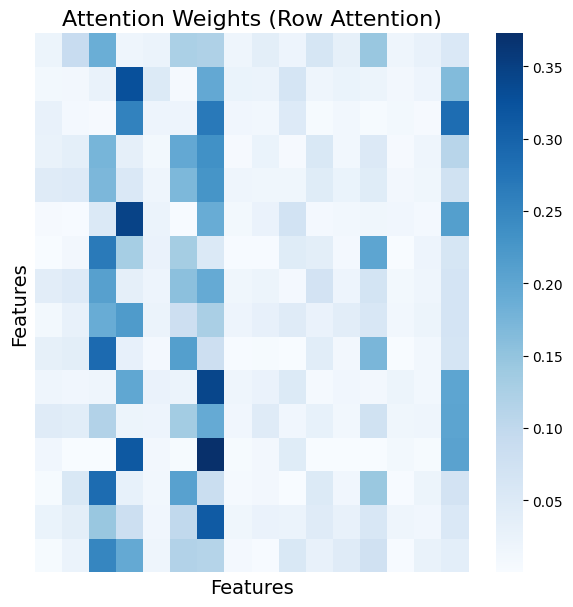

In [186]:
model = CrossAttentionModel(input_dim=16, seq_len=40, hidden_dim=64, dropout_rate=0.15) 
model.load_state_dict(torch.load('/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/ML_models/eight_sample_11features_test/DL_saved/attnetion_plot_45epoch_0.15drop_nopos/best_model_epoch_45_auc_0.813.pth'))
model.eval()

for x, y in test_loader:
    # print(x.shape, y.shape)
    input_tensor = x
    break

attention_weights_list = []  # 用于存储 attention_weights

def capture_row_attention_weights(module, input, output):
    # 这里的output[1]是注意力权重
    attention_weights = output[1]  # shape: (batch_size, seq_len, seq_len)
    attention_weights_list.append(attention_weights.cpu().detach().numpy())

    
row_hook = model.row_attention.register_forward_hook(capture_row_attention_weights)
output = model(input_tensor)
first_sample_attention_weights = attention_weights_list[0]
average_attention_weights = np.mean(attention_weights_list[0], axis=0)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.heatmap(average_attention_weights , cmap='Blues', annot=False, xticklabels=False, yticklabels=False)
plt.title('Attention Weights (Row Attention)', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

row_hook.remove()

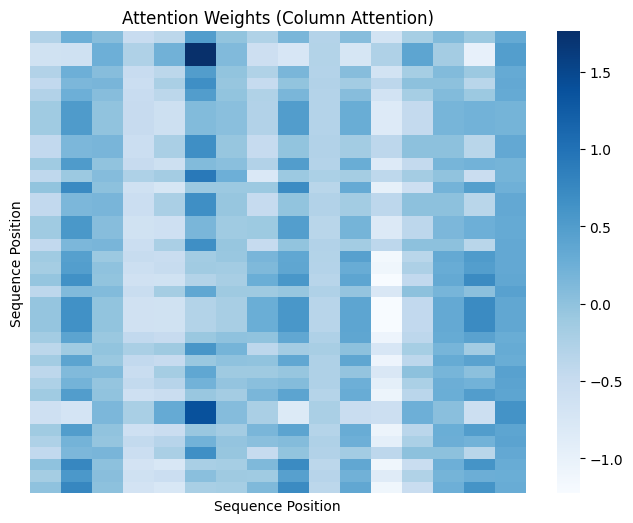

In [106]:
# 这是一个错误示范，在没有返回attention_weight的情况下，直接调用attention_weight，错误的将返回的output当作attention_weight
model = CrossAttentionModel(input_dim=16, seq_len=40, hidden_dim=64, dropout_rate=0.15) 
model.load_state_dict(torch.load('/BioII/lulab_b/huangkeyun/zhangys/alkb-seq/ML_models/eight_sample_11features_test/DL_saved/11f_test0.2_nostop_60epoches_0.15drop_nopos/best_model_epoch_60_auc_0.860.pth'))
model.eval()

for x, y in train_loader:
    # print(x.shape, y.shape)
    input_tensor = x
    break

attention_weights_list = []  # 用于存储 attention_weights

def capture_column_attention_weights(module, input, output):
    # 这里的output[1]是注意力权重
    attention_weights = output[1]  # shape: (batch_size, seq_len, seq_len)
    attention_weights_list.append(attention_weights.cpu().detach().numpy())


column_hook = model.column_attention.register_forward_hook(capture_column_attention_weights)
# input_tensor = torch.rand(64, 40, 16)
output = model(input_tensor)
first_sample_attention_weights = attention_weights_list[0]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(first_sample_attention_weights, cmap='Blues', annot=False, xticklabels=False, yticklabels=False)
plt.title('Attention Weights (Column Attention)')
plt.xlabel('Sequence Position')
plt.ylabel('Sequence Position')
plt.show()

# 移除钩子
column_hook.remove()

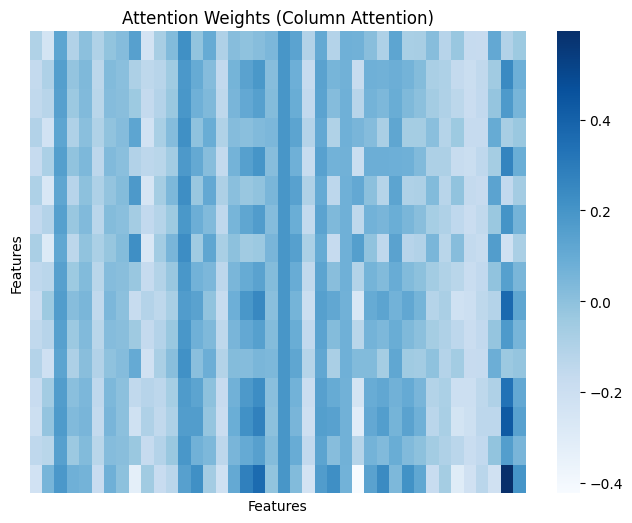

In [107]:
attention_weights_list = []  # 用于存储 attention_weights

def capture_row_attention_weights(module, input, output):
    # 这里的output[1]是注意力权重
    attention_weights = output[1]  # shape: (batch_size, seq_len, seq_len)
    attention_weights_list.append(attention_weights.cpu().detach().numpy())

    
model = CrossAttentionModel(input_dim=16, seq_len=40, hidden_dim=64, dropout_rate=0.15) 
row_hook = model.row_attention.register_forward_hook(capture_row_attention_weights)
input_tensor = torch.rand(32, 40, 16)
output = model(input_tensor)
first_sample_attention_weights = attention_weights_list[0]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(first_sample_attention_weights, cmap='Blues', annot=False, xticklabels=False, yticklabels=False)
plt.title('Attention Weights (Column Attention)')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

row_hook.remove()